In [1]:
from importlib.metadata import requires
import os
from math import ceil
from re import I
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
# import torchmetrics as thm
import LPGNN
import igraph as ig
import networkx as nx
import torch_geometric as pyg

import pyarrow as pa
import pyarrow.parquet as pq

import importlib
import powerlaw

import imageio

from tqdm import tqdm


2022-10-12 15:16:16.856991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-12 15:16:16.857050: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [40]:
importlib.reload(LPGNN.labne)

<module 'LPGNN.labne' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/labne.py'>

In [2]:
# using pyg, import the WordNet dataset

# download WordNet18RR

WordNet18RR = pyg.datasets.WordNet18RR(root='data/WordNet18RR')

In [3]:
WordNet18RR.data

Data(edge_index=[2, 93003], edge_type=[93003], train_mask=[93003], val_mask=[93003], test_mask=[93003], num_nodes=40943)

In [4]:
def print_edge_type(idx):
    print(WordNet18RR.data.edge_index[0][idx].item(), '<-', WordNet18RR.data.edge_type[idx].item(), '->', WordNet18RR.data.edge_index[1][idx].item())

In [5]:
for i in range(20):
    print_edge_type(i)

0 <- 3 -> 10211
0 <- 9 -> 25525
1 <- 10 -> 3891
1 <- 1 -> 5070
1 <- 1 -> 7723
1 <- 1 -> 8949
1 <- 10 -> 13390
2 <- 1 -> 4129
2 <- 1 -> 7987
2 <- 3 -> 25354
3 <- 4 -> 38179
4 <- 1 -> 6642
4 <- 1 -> 7037
4 <- 1 -> 9333
4 <- 3 -> 12750
4 <- 1 -> 24122
5 <- 5 -> 4386
5 <- 5 -> 5017
5 <- 5 -> 9745
5 <- 5 -> 15087


In [6]:
# draw the WordNet18RR train graph. This is an undirected graph with 10 edge types
# draw each edge type with a different color

# convert to networkx
WordNet18RR_nx = pyg.utils.to_networkx(WordNet18RR.data)

In [7]:
WordNet18RR_nx.number_of_edges()

92879

In [8]:
WordNet18RR_data = WordNet18RR.data

In [53]:
WN_LaBNE = LPGNN.labne.generateLaBNE(WordNet18RR_data, normalize_radius=False, dim=4)

In [54]:
positions = WN_LaBNE.LaBNE_node_positions.detach().numpy()
colors = WN_LaBNE.LaBNE_node_polar_positions[:,1].detach().numpy()

In [55]:
WN_LaBNE

Data(edge_index=[2, 93003], edge_type=[93003], train_mask=[93003], val_mask=[93003], test_mask=[93003], num_nodes=40943, gamma=3.5172178110569905, LaplacianEigenmaps_node_positions=[40943, 4], LaBNE_node_polar_positions=[40943, 4], LaBNE_node_positions=[40943, 4])

In [56]:
positions

array([[  4.417623 ,   4.417622 ,   5.4362855, -18.516321 ],
       [  4.9546075,   4.9546084,   3.7637525, -16.99589  ],
       [  3.5561287,   3.5561297,   6.2503943, -18.226345 ],
       ...,
       [ 12.446419 ,  12.44642  ,  11.198417 ,  -3.9628549],
       [  5.000871 ,   5.0008717, -14.377895 ,  13.935324 ],
       [ -5.072746 ,  -5.0727463,  14.322916 , -13.939954 ]],
      dtype=float32)

In [59]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection='3d'))

ax.scatter(positions[:,2], positions[:,1], positions[:,3],  s=1, cmap='hsv', c=colors)

In [13]:
init_pos = WN_LaBNE.LaBNE_node_positions

In [20]:
epochs = 2500
for i in tqdm(range(epochs)):

    WN_Poincare = LPGNN.poincare_embedding.poincare_embedding(WN_LaBNE, epochs=50, lr=0.001, expm='exact', init_pos=init_pos, r_ordering=False)
    init_pos = WN_Poincare.PoincareEmbedding_node_positions
    
    polar_pos = LPGNN.distances.to_spherical(init_pos)
    r_max = polar_pos[:, 0].max()
    r = LPGNN.labne.radial_ordering(WN_Poincare, 'edge_index')
    # scale from [r.min(), r.max()] to [., r_max]
    r *= r_max/r.max()
    # reshape r to be [num_nodes, 1]
    polar_pos[:, 0] = r
    init_pos = LPGNN.distances.to_cartesian(polar_pos)

 25%|██▍       | 621/2500 [08:54<14:48:12, 28.36s/it]

: 

: 

In [15]:
positions = WN_Poincare.PoincareEmbedding_node_positions.detach().numpy()

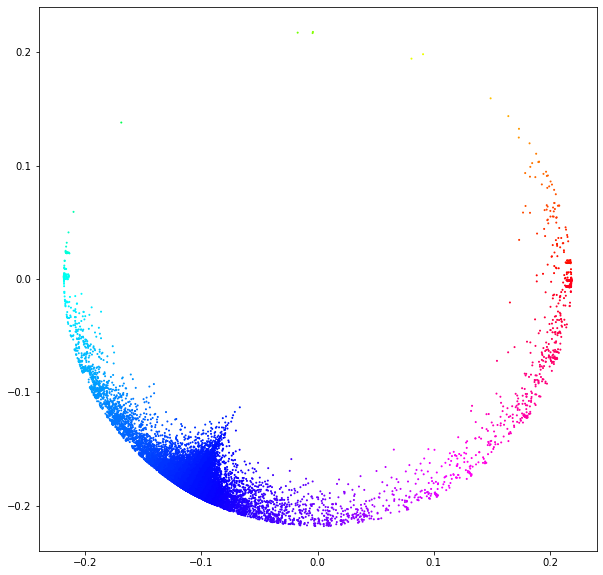

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(positions[:,0], positions[:,1], s=1, cmap='hsv', c=colors)